In [2]:
import tensorflow as tf
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from gensim.models import KeyedVectors
from gensim.parsing.preprocessing import remove_stopwords
import collections
from collections import defaultdict
import os
import re
import pickle
from gpt2.src.score import score_model
from gpt2.src.generate_prompt import generate_prompt
from gpt2.src.encoder import get_encoder
from py_files.Limericks import Limerick_Generate
lg = Limerick_Generate(model_name='345M')

E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [4]:
in_path = 'py_files/saved_objects/silly_poems.txt'

batch_size = 10
model_name = '345M'
enc = get_encoder(model_name)

In [6]:
in_txt = open(in_path, 'rb')
lines = [[],[],[],[],[]]

counter = 0
for line in in_txt:
    line = line.rstrip().decode('utf-8')
    if len(line) < 5:
        continue
    lines[counter].append([re.sub('[^a-zA-Z]+', '', word.lower()) for word in line.split()])
    counter += 1
    counter %= 5
poems = []
for i in range(0, len(lines[0])):
    poems.append(lines[0][i] + lines[1][i] + lines[2][i] + lines[3][i] + lines[4][i])

In [6]:
encodes = [[[], poems[i], [], 0] for i in range(len(poems))]
finished = []
index = 10
while True:
    new_encodes = []
    for i in range(len(encodes)):
        if len(encodes[i][0]) < len(encodes[i][1]):
            encodes[i][0].append(enc.encode(encodes[i][1][index])[0])
            new_encodes.append(encodes[i])
        else:
            finished.append(encodes[i])
    index += 1
    encodes = new_encodes
    logits = score_model(model_name=model_name, context_token=[e[0] for e in encodes])
    for i in range(len(encodes)):
        # Calculate logit score
        for j in range(len(logits[i])):
            word = enc.decode([j]).lower().strip()
            if word == encodes[i][1][index + 1]:
                encodes[i][2].append(np.log(logits[i][j]))
                break
        else:
            print("word not found!!!") 
        # Calculate WEMA
        embedding_distance = lg.get_word_similarity(word, [encodes[i][1][-1]])
        encodes[i][3] = (1 - lg.word_embedding_alpha) * encodes[i][3] + lg.word_embedding_alpha * embedding_distance \
                         if embedding_distance is not None \
                         else encodes[i][3]
    if index == 15:
        break

INFO:tensorflow:Restoring parameters from gpt2/models\345M\model.ckpt
word not found!!!
word not found!!!
INFO:tensorflow:Restoring parameters from gpt2/models\345M\model.ckpt
word not found!!!
word not found!!!
INFO:tensorflow:Restoring parameters from gpt2/models\345M\model.ckpt
word not found!!!
word not found!!!
INFO:tensorflow:Restoring parameters from gpt2/models\345M\model.ckpt
word not found!!!
word not found!!!
INFO:tensorflow:Restoring parameters from gpt2/models\345M\model.ckpt
word not found!!!


In [7]:
for encode in encodes:
    print(encode[1])
    print(np.mean(encode[2]) + lg.word_embedding_coefficient*encode[3])
    print("------")

['there', 'was', 'a', 'kind', 'girl', 'whose', 'name', 'is', 'jane', 'a', 'girl', 'who', 'i', 'did', 'not', 'know', 'he', 'then', 'added', 'she', 'had', 'tons', 'of', 'luggage', 'it', 'seemed', 'i', 'could', 'walk', 'where', 'she']
-8.519290861487388
------
['there', 'was', 'a', 'kind', 'girl', 'whose', 'name', 'is', 'jane', 'we', 'are', 'not', 'actually', 'marissa', 'now', 'determine', 'her', 'said', 'harry', 'at', 'once', 'cause', 'he', 'has', 'her', 'dna', 'on', 'him']
-11.186942100524902
------
['there', 'was', 'a', 'kind', 'girl', 'whose', 'name', 'is', 'jane', 'she', 'went', 'by', 'the', 'name', 'mama', 'or', 'mama', 'roger', 'if', 'she', 'so', 'wanted', 'to', 'who', 'wanted', 'to', 'be', 'mama', 'roger']
-11.288053512573242
------
['there', 'was', 'a', 'kind', 'girl', 'whose', 'name', 'is', 'jane', 'she', 'became', 'a', 'confederate', 'soldier', 'lived', 'by', 'herself', 'and', 'then', 'died', 'young', 'after', 'four', 'years', 'she', 'moved', 'to', 'huachuca']
-12.5698719024658

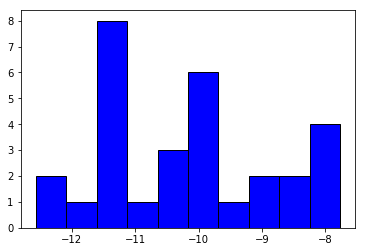

In [15]:
import matplotlib.pyplot as plt

plt.hist([np.mean(encode[2]) + lg.word_embedding_coefficient*encode[3] for encode in encodes], 
         color = 'blue', edgecolor = 'black', bins = 10)
plt.show()

In [27]:
print("score generated successfully")
now = datetime.now().time() # time object
file_name = "limericks_data_experiment/" + str(len(poems)) + "_poems_generated_at_" + now.strftime("%H_%M_%S") + ".p"
print("saved at " + file_name)
pickle.dump(encodes, open(file_name, "wb"))

score generated successfully
saved at limericks_data_experiment/30_poems_generated_at_23_59_55.p
